# Trabajo practico integrador: Parte 2
## [Crimenes ocurridos en la ciudad de Chicago (2024)](https://data.cityofchicago.org/Public-Safety/Crimes-in-Chicago/ijzp-q8t2)

### Grupo: 9
### Alumno: Maxim Dorogov

## Objetivo
El objetivo de este trabajo es realizar una preparacion de datos (limpieza, correccion, feature engineering y split), para resolver un problema de clasificacion sobre un dataset de los crimenes ocurridos en la ciudad de Chicago en el año 2024. Para ello vamos a partir del dataset utilizado en la parte 1 del trabajo practico del cual se eliminaron columnas que no eran relevantes para el analisis. La columna `Arrest` sera considerada como nuestro taget para un problema de clasificacion binaria, donde el objetivo es predecir si un crimen resulto en un arresto o no.

In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from category_encoders import HashingEncoder, TargetEncoder

In [26]:
df = pd.read_csv('Crimes_-_2024_20250701_filtered.csv')
df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
0,12/31/2024 11:58:00 PM,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,332,3,5,43.0,14,1186817.0,1860189.0,41.771470,-87.590742
1,12/31/2024 11:56:00 PM,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,223,2,3,38.0,26,1179661.0,1873623.0,41.808501,-87.616563
2,12/31/2024 11:55:00 PM,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,834,8,18,70.0,04B,1145740.0,1853048.0,41.752749,-87.741498
3,12/31/2024 11:53:00 PM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,321,3,20,42.0,14,1184362.0,1861188.0,41.774269,-87.599710
4,12/31/2024 11:50:00 PM,BATTERY,SIMPLE,SIDEWALK,False,False,2531,25,29,25.0,08B,1137458.0,1907694.0,41.902858,-87.770537


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258378 entries, 0 to 258377
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  258378 non-null  object 
 1   Primary Type          258378 non-null  object 
 2   Description           258378 non-null  object 
 3   Location Description  257325 non-null  object 
 4   Arrest                258378 non-null  bool   
 5   Domestic              258378 non-null  bool   
 6   Beat                  258378 non-null  int64  
 7   District              258378 non-null  int64  
 8   Ward                  258378 non-null  int64  
 9   Community Area        258376 non-null  float64
 10  FBI Code              258378 non-null  object 
 11  X Coordinate          257370 non-null  float64
 12  Y Coordinate          257370 non-null  float64
 13  Latitude              257370 non-null  float64
 14  Longitude             257370 non-null  float64
dtype

### Tratamiento de datos faltantes y duplicados


In [28]:
# Identifico columnas con faltantes y sus respectivas cantidades
missing_columns = df.isnull().sum()
missing_columns[missing_columns > 0]

Location Description    1053
Community Area             2
X Coordinate            1008
Y Coordinate            1008
Latitude                1008
Longitude               1008
dtype: int64

Algo que se discutio brevemente en el trabajo anterior fue la posible correlacion entre X Coordinate, Y Coordinate con Latitude, Longitude. Ya que en la documentacion se
indica que las coordenadas X e Y son las coordenadas de la ubicacion del crimen en un sistema de coordenadas particular, mientras que Latitude y Longitude son las coordenadas geograficas. Por lo tanto, se puede intuir que X Coordinate y Y Coordinate son equivalentes a Latitude y Longitude. Para confirmar esto calculamos y graficamos la correlacion entre las columnas X Coordinate, Y Coordinate y Latitude, Longitude. 

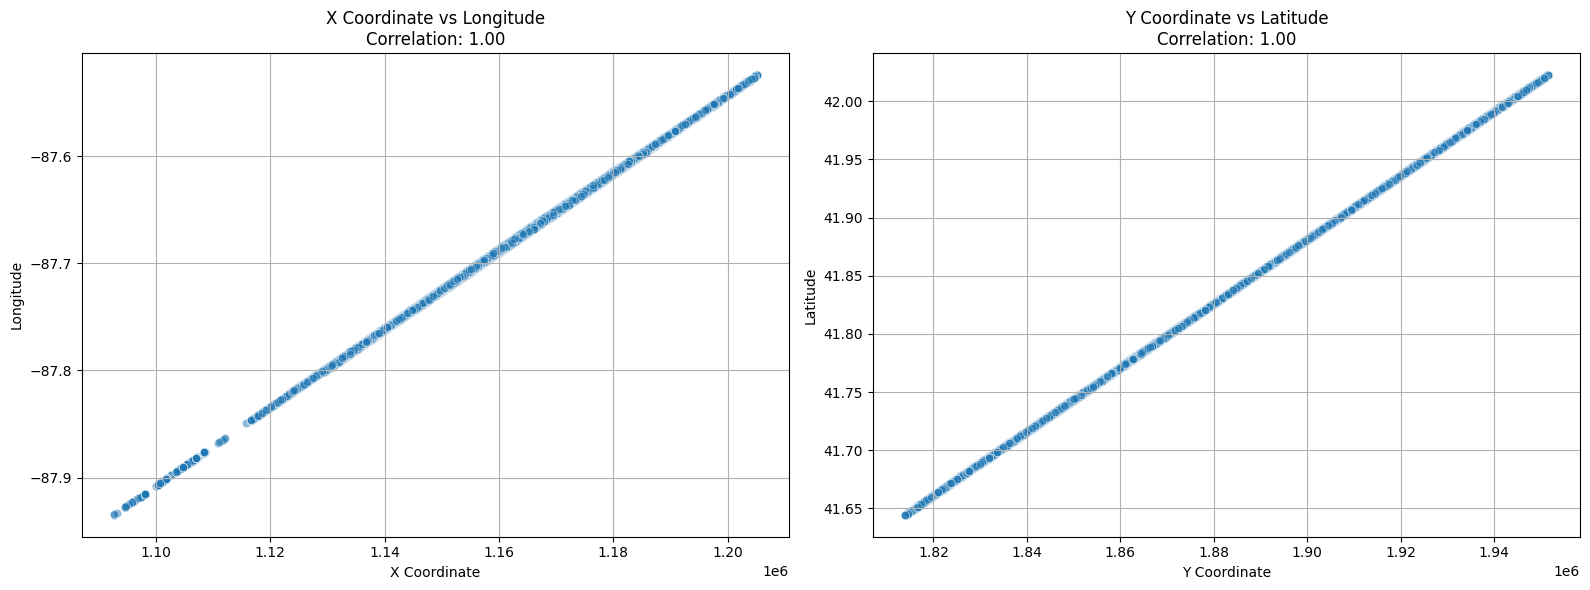

In [29]:
# Calculate correlations
correlation_long_x = df[['X Coordinate', 'Longitude']].corr().iloc[0, 1]
correlation_lat_y = df[['Y Coordinate', 'Latitude']].corr().iloc[0, 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Scatter plot for X Coordinate vs Longitude
sns.scatterplot(data=df, x='X Coordinate', y='Longitude', alpha=0.5, ax=axes[0])
axes[0].set_title(f"X Coordinate vs Longitude\nCorrelation: {correlation_long_x:.2f}")
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Longitude')
axes[0].grid(True)

# Scatter plot for Y Coordinate vs Latitude
sns.scatterplot(data=df, x='Y Coordinate', y='Latitude', alpha=0.5, ax=axes[1])
axes[1].set_title(f"Y Coordinate vs Latitude\nCorrelation: {correlation_lat_y:.2f}")
axes[1].set_xlabel('Y Coordinate')
axes[1].set_ylabel('Latitude')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

Eliminamos las columnas X Coordinate, Y Coordinate y dejamos las columnas Latitude, Longitude debido a que representan la misma informacion y pueden considerarse como datos duplicados.

In [30]:
df.drop(columns=['X Coordinate', 'Y Coordinate'], inplace=True)

Tenemos 1008 entradas faltantas para `Latitude` y `Longitude`, lo que representa solo un 0.4% del total de filas. Por lo tanto, eliminamos las filas con datos faltantes en estas columnas. Hacemos lo mismo con `Location Description` y `Community Area` ya que tienen un porcentaje de datos faltantes similar o menor.

>NOTA: `Latitude` y `Longitude` son variables que representan la ubicacion geografica del crimen, por eso se descarto la opcion de imputar los datos faltantes con tecnicas de imputacion ya que al hacer esto estariamos introduciendo ruido en los datos y afectando la calidad del modelo. Idem con `Location Description` ya que al ser una variable categorica de texto, es mejor eliminar las filas con datos faltantes (mas cuando la proporcion es tan pequenia) que imputar un valor que no tenga sentido. 

In [31]:
# Solo tengo nulos en las columnas mencionadas arriba, hacemos un drop sobre
# el dataframe para eliminar filas con faltantes.
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256333 entries, 0 to 258377
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  256333 non-null  object 
 1   Primary Type          256333 non-null  object 
 2   Description           256333 non-null  object 
 3   Location Description  256333 non-null  object 
 4   Arrest                256333 non-null  bool   
 5   Domestic              256333 non-null  bool   
 6   Beat                  256333 non-null  int64  
 7   District              256333 non-null  int64  
 8   Ward                  256333 non-null  int64  
 9   Community Area        256333 non-null  float64
 10  FBI Code              256333 non-null  object 
 11  Latitude              256333 non-null  float64
 12  Longitude             256333 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(5)
memory usage: 24.0+ MB


### Creacion de nuevas caracteristicas

Las unicas columnas no categoricas que tenemos son `Latitude` y `Longitude`, las cuales representan coordenadas geograficas. Estas coordenadas varian entre -90 y 90 para `Latitude` y entre -180 y 180 para `Longitude` lo cual hace que se tenga que tener especial cuidado al momento de aplicar algoritmos basados en distancias ya que al ser coordenadas 2d que representan ubicaciones en una esfera, la distancia entre dos puntos no es lineal ni se puede tratar como si fuera un espacio euclidiano. Una transformacion util, que mapea las coordenadas a un espacio mas adecuado para el analisis, es la transformacion de las coordenadas a un sistema de coordenadas cartesianas. Esto se puede hacer utilizando la siguiente formula:

```
x = cos(Latitude) * cos(Longitude)
y = cos(Latitude) * sin(Longitude)
z = sin(Latitude)
```

Para aplicar esta transformacion, primero convertimos las coordenadas de grados a radianes y luego aplicamos la formula. Esto nos permite trabajar con las coordenadas de una manera mas adecuada para el analisis y evita problemas de distancias no lineales dejando los valores normalizados en un rango de -1 a 1 a los cuales si se les puede aplicar min-max scaling o z-score normalization.

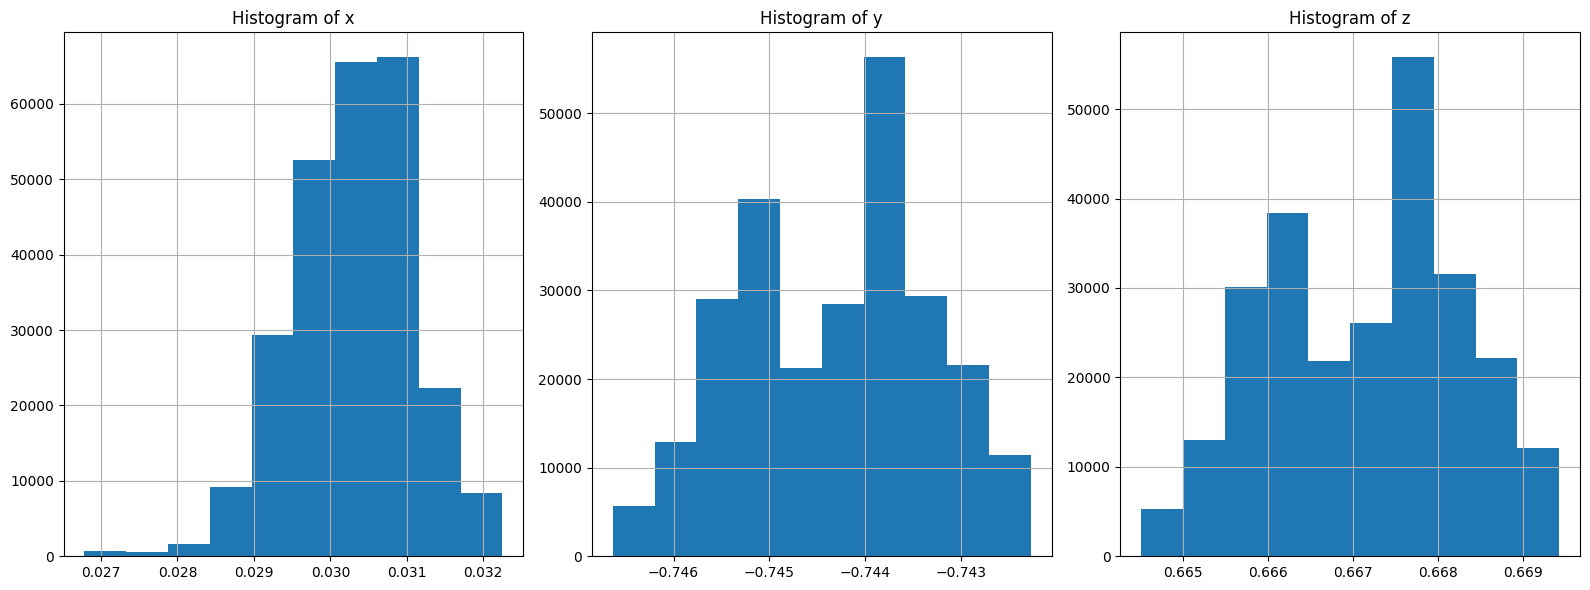

In [32]:
latitude_radians = np.radians(df['Latitude'])
longitude_radians = np.radians(df['Longitude'])

# Creamos 3 columnas nuevas con los nuevos datos geograficos
df['x'] = np.cos(latitude_radians) * np.cos(longitude_radians)
df['y'] = np.cos(latitude_radians) * np.sin(longitude_radians)
df['z'] = np.sin(latitude_radians)

plt.figure(figsize=(16, 6))
plt.subplot(131)
df['x'].hist()
plt.title('Histogram of x')
plt.subplot(132)
df['y'].hist()
plt.title('Histogram of y')
plt.subplot(133)
df['z'].hist()
plt.title('Histogram of z')
plt.tight_layout()


Con esta transformacion creamos nuevas features con una dimensionalidad mayor, pero que representan mejor la informacion geografica de los crimenes volviendo la informacion apta para ser utilizada en modelos de machine learning. La idea no es reemplazar las columnas originales `Latitude` y `Longitude`, sino complementarlas con estas nuevas features.
>NOTA: Esta transformacion no es estrictamente necesaria, pero puede mejorar el rendimiento de los modelos que utilizan distancias para hacer predicciones.

### Train - Test Split

En este punto, previo a aplicar tranformaciones globales, realizamos la separacion entre train y test. Utilizamos un 80% de los datos para entrenamiento y un 20% para test.

Vemos como se distribuye la variable target.

Porcentage of arrests: 13.82%
Porcentage of non arrests: 86.18%


/tmp/ipykernel_7940/1332497759.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Arrest'], palette='Set2')


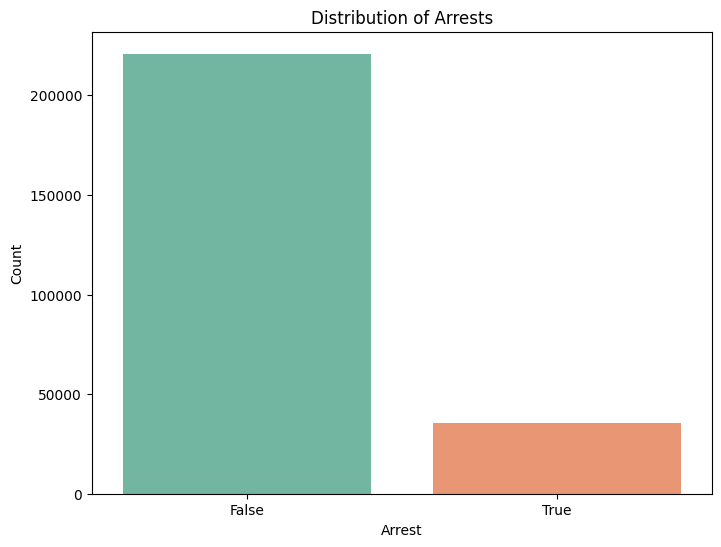

In [33]:
total = len(df)
# contamos cuantos arrestos hay
arrests_count = df['Arrest'].value_counts()
arrest = arrests_count.get(True)
non_arrest = arrests_count.get(False)
print(f'Porcentage of arrests: {arrest / total * 100:.2f}%')
print(f'Porcentage of non arrests: {non_arrest / total * 100:.2f}%')

# Vemos la distribucon de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Arrest'], palette='Set2')
plt.title('Distribution of Arrests')
plt.xlabel('Arrest')
plt.ylabel('Count')
plt.show()

Vemos que hay un orden de magnitud que diferencia la cantidad entre las clases, ya que el 86% de los crimenes no resultaron en arresto. Hay un desbalance muy fuerte entre las clases. AL momento de entrenar un modelo una opcion en estos casos es armar un sampler que selecciones las clases de manera tal que en cada batch el modelo vea una proporcion similar de ambas clases. Esto se puede hacer utilizando la clase `WeightedRandomSampler` de Pytorch, que permite muestrear las clases de manera ponderada. Otra opcion es utilizar tecnicas de oversampling o undersampling para balancear las clases.

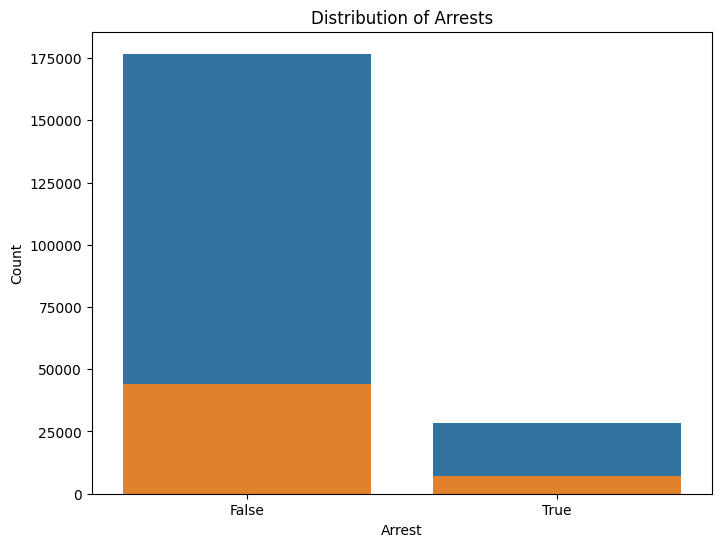

In [34]:
from sklearn.model_selection import train_test_split

Y = df['Arrest']

# Usamos stratify para mantener la proporcion de clases en test y train
x_train, x_test, y_train, y_test = train_test_split(
    df, Y, test_size=0.2, random_state=42, stratify=Y)


plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
sns.countplot(x=y_test)
plt.title('Distribution of Arrests')
plt.xlabel('Arrest')
plt.ylabel('Count')
plt.show()

En lo personal prefiero utilizar `WeightedRandomSampler` o un algoritmo similar para balancear las clases durante el proceso de entrenamiento ya que permite mantener la distribucion original de los datos y evita perder informacion valiosa al eliminar filas o generar ruido agregando valores que no existen en los datos originales. A efectos del trabajo practico, vamos a utilizar la tecnica de oversampling con SMOTE para balancear las clases. 
Aplicamos SMOTE (luego de terminar las transformaciones y creacion de features ya que no es posible aplicar oversampling a algunas de las variables categoricas) unicamente a train ya que el conjunto de test deberia reflejar la verdadera naturaleza de los datos.

In [35]:
df = x_train

### Normalizacion de datos

Llevamos las nuevas categorias numericas que agregamos al rango 0 - 1

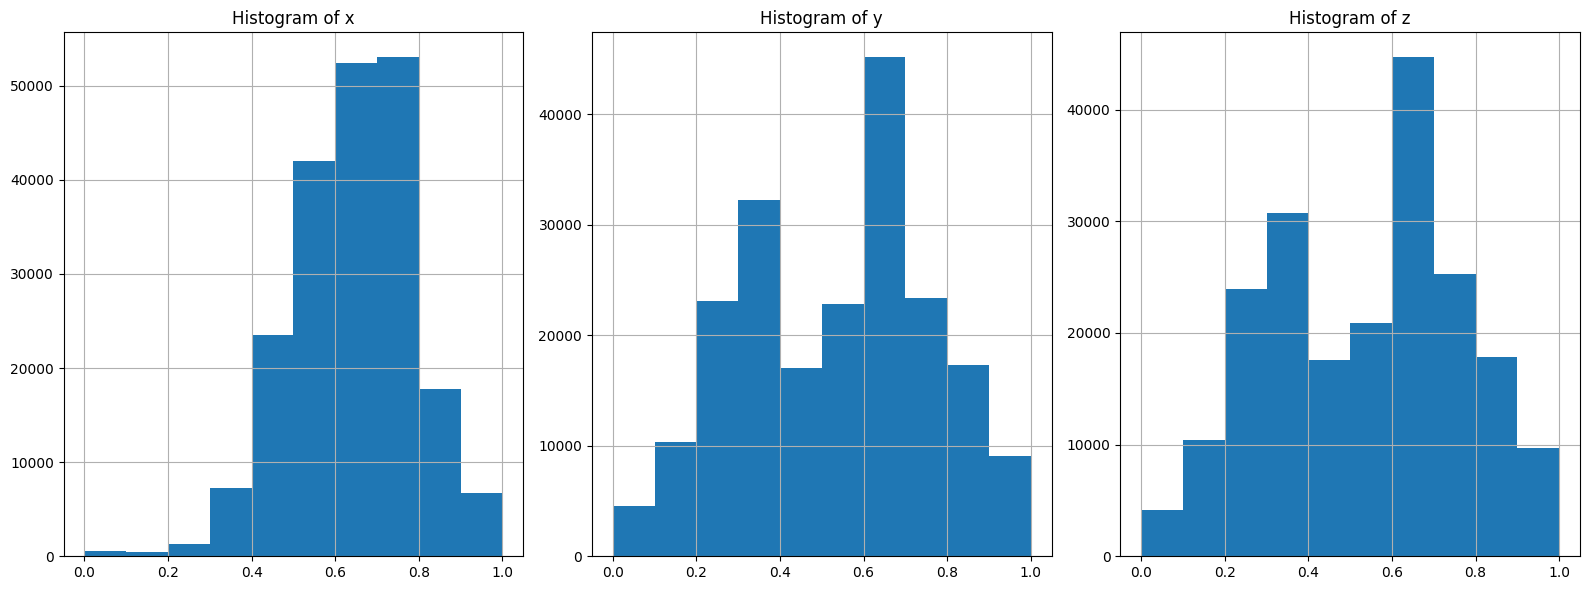

In [36]:
scaler = MinMaxScaler()
# Normalizamos las nuevas columnas
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

plt.figure(figsize=(16, 6))
plt.subplot(131)
df['x'].hist()
plt.title('Histogram of x')
plt.subplot(132)
df['y'].hist()
plt.title('Histogram of y')
plt.subplot(133)
df['z'].hist()
plt.title('Histogram of z')
plt.tight_layout()

In [37]:
# Hacemos lo mismo para los datos de test
x_test[['x', 'y', 'z']] = scaler.transform(x_test[['x', 'y', 'z']])

### Codificacion de variables categoricas

Se aplicara Hashing Encoding para las variables de texto y Target Encoding para el resto de las variables categoricas. Esto se debe a que las variables de texto pueden tener una gran cantidad de categorias y el Hashing Encoding permite reducir la dimensionalidad del dataset, mientras que el Target Encoding permite capturar la relacion entre las categorias y el target.

In [38]:
cols = [
    'Primary Type', 
    'Description', 
    'Location Description',
    'Ward',
    'Beat',
    'District',
    'Community Area',
    'FBI Code']
for col in cols:
    print(f'Cantidad de categorías en {col}: {df[col].nunique()} \n')

Cantidad de categorías en Primary Type: 31 

Cantidad de categorías en Description: 310 

Cantidad de categorías en Location Description: 124 

Cantidad de categorías en Ward: 50 

Cantidad de categorías en Beat: 275 

Cantidad de categorías en District: 23 

Cantidad de categorías en Community Area: 77 

Cantidad de categorías en FBI Code: 26 



In [39]:
# Usamos hashing para codificar las columnas categóricas de texto que contienen
# descripciones

# Como una regla de pulgar, usamos la raiz cuadrada del número de categorías 
# únicas en cada columna, en la practica tomaria este numero como un minimo 
# y lo ajustaria segun el rendimiento del modelo aplicando validación cruzada.

description_encoder = HashingEncoder(
    n_components=int(np.sqrt(df['Description'].nunique())))
loc_description_encoder = HashingEncoder(
    n_components=int(np.sqrt(df['Location Description'].nunique())))
primary_type_encoder = HashingEncoder(
    n_components=int(np.sqrt(df['Primary Type'].nunique())))

# Aplicamos el encoder a las columnas
encoded_desc = description_encoder.fit_transform(df['Description'])
encoded_loc_desc = loc_description_encoder.fit_transform(
    df['Location Description'])
encoded_primary_type = primary_type_encoder.fit_transform(df['Primary Type'])

encoded_desc.columns = [
    f'description_{i}' for i in range(encoded_desc.shape[1])]
encoded_loc_desc.columns = [
    f'location_description_{i}' for i in range(encoded_loc_desc.shape[1])]
encoded_primary_type.columns = [
    f'primary_type_{i}' for i in range(encoded_primary_type.shape[1])]

df.drop(columns=[
    'Description', 'Location Description', 'Primary Type'], inplace=True)

# Concatenamos los dataframes codificados con el original
df = pd.concat([df, encoded_desc, encoded_loc_desc, encoded_primary_type], axis=1)
df.head()

,Date,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,...,location_description_6,location_description_7,location_description_8,location_description_9,location_description_10,primary_type_0,primary_type_1,primary_type_2,primary_type_3,primary_type_4
80286,09/06/2024 08:00:00 AM,False,False,122,1,42,32.0,10,41.881017,-87.632340,...,0,1,0,0,0,0,0,1,0,0
190568,04/12/2024 05:19:00 AM,True,False,1024,10,24,29.0,08A,41.856790,-87.708424,...,0,0,0,0,0,0,0,1,0,0
83464,09/02/2024 01:51:00 AM,False,False,2422,24,49,1.0,08A,42.019381,-87.672426,...,0,0,0,0,0,0,1,0,0,0
142561,06/16/2024 02:00:00 PM,False,False,1713,17,33,14.0,14,41.968408,-87.712747,...,0,0,0,0,0,0,1,0,0,0
18758,12/02/2024 03:30:00 AM,False,True,1523,15,37,25.0,14,41.882965,-87.764953,...,1,0,0,0,0,0,1,0,0,0


In [40]:
# replicamos los pasos para los datos de test
encoded_desc_test = description_encoder.transform(x_test['Description'])
encoded_loc_desc_test = loc_description_encoder.transform(
    x_test['Location Description'])
encoded_primary_type_test = primary_type_encoder.transform(
    x_test['Primary Type'])
encoded_primary_type.columns = [
    f'primary_type_{i}' for i in range(encoded_primary_type.shape[1])]
x_test.drop(columns=[
    'Description', 'Location Description', 'Primary Type'], inplace=True)
x_test = pd.concat([x_test, encoded_desc, encoded_loc_desc, encoded_primary_type], axis=1)
x_test.head()

,Date,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,...,location_description_6,location_description_7,location_description_8,location_description_9,location_description_10,primary_type_0,primary_type_1,primary_type_2,primary_type_3,primary_type_4
96119,08/15/2024 10:00:00 PM,False,False,2411.0,24.0,50.0,2.0,14,42.015741,-87.697858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5845,12/22/2024 06:00:00 AM,False,False,2512.0,25.0,36.0,19.0,08A,41.923821,-87.776019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86206,08/29/2024 06:05:00 PM,False,False,1913.0,19.0,46.0,3.0,06,41.965742,-87.665523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220323,02/27/2024 08:00:00 PM,False,False,1652.0,16.0,41.0,76.0,11,41.976421,-87.904976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250617,01/12/2024 01:00:00 PM,False,False,1213.0,12.0,1.0,24.0,11,41.896045,-87.668997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
encoded = TargetEncoder(cols=['Ward', 'Beat', 'District', 'Community Area', 'FBI Code'])
# Aplicamos el encoder a las columnas
df = encoded.fit_transform(
    df, y_train)
# Normalizamos las columnas codificadas al mismo rango [0, 1]
df[['Ward', 'Beat', 'District', 'Community Area', 'FBI Code']] = scaler.fit_transform(
    df[['Ward', 'Beat', 'District', 'Community Area', 'FBI Code']])
df.head()

,Date,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,...,location_description_6,location_description_7,location_description_8,location_description_9,location_description_10,primary_type_0,primary_type_1,primary_type_2,primary_type_3,primary_type_4
80286,09/06/2024 08:00:00 AM,False,False,0.238411,0.515407,0.598898,0.689550,0.021292,41.881017,-87.632340,...,0,1,0,0,0,0,0,1,0,0
190568,04/12/2024 05:19:00 AM,True,False,0.442036,0.554373,1.000000,0.706170,0.040020,41.856790,-87.708424,...,0,0,0,0,0,0,0,1,0,0
83464,09/02/2024 01:51:00 AM,False,False,0.537312,0.175291,0.504270,0.453822,0.040020,42.019381,-87.672426,...,0,0,0,0,0,0,1,0,0,0
142561,06/16/2024 02:00:00 PM,False,False,0.169114,0.137391,0.262002,0.300095,0.010800,41.968408,-87.712747,...,0,0,0,0,0,0,1,0,0,0
18758,12/02/2024 03:30:00 AM,False,True,0.333571,0.450890,0.745751,0.550877,0.010800,41.882965,-87.764953,...,1,0,0,0,0,0,1,0,0,0


In [42]:
# idem para test
x_test = encoded.transform(x_test)
# Normalizamos las columnas codificadas al mismo rango [0, 1]
x_test[['Ward', 'Beat', 'District', 'Community Area', 'FBI Code']] = scaler.transform(
    x_test[['Ward', 'Beat', 'District', 'Community Area', 'FBI Code']])

### Filtrado y reduccion de dimensionalidad

Tenemos varias columnas que aportan informacion espacial, como `District`, `Ward`, `Community Area` y `Beat`. Estas columnas representan diferentes niveles de division geografica en la ciudad de Chicago. Dado que ya tenemos las coordenadas geografias (Latitude y Longitude) y las transformaciones a coordenadas cartesianas, estas columnas pueden considerarse redundantes. Ademas, al ser variables categoricas con muchas categorias, pueden introducir ruido en el modelo. Una vez que las transformamos a variables numericas podemos aplicar tecnicas de filtrado para eliminar las columnas que no aportan informacion relevante para el modelo.

<Axes: >

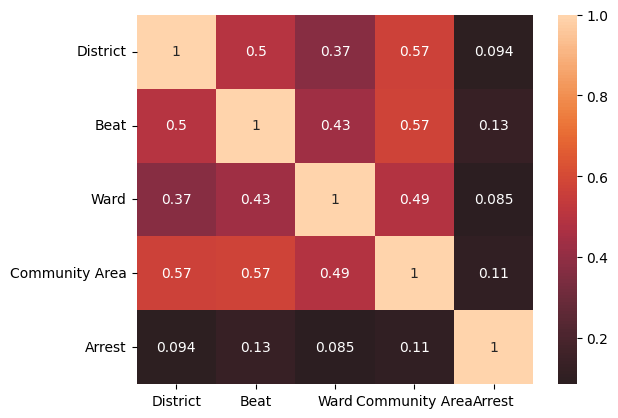

In [43]:
sns.heatmap(df[['District', 'Beat', 'Ward', 'Community Area', 'Arrest']].corr(method='kendall'), center=0, annot=True)

Se observa que si bien hay cierta correlacion entre algunas de las variables (Community Area con Beat y con District y a su vez tambien entre Beat y District) esto no parece se suficiente para tomar una decision. Analizamos la informacion mutua para ver si podemos extraer alguna relacion entre estas variables y el target (Arrest).

In [44]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k='all')
best_features = selector.fit_transform(
    df[['District', 'Beat','Ward', 'Community Area']], df['Arrest'])

In [45]:
feature_scores = pd.Series(selector.scores_, index=['District', 'Beat', 'Ward', 'Community Area'])
print(feature_scores)

District          0.008968
Beat              0.014362
Ward              0.007297
Community Area    0.011299
dtype: float64


A partir de analizar los maximos en la informacion mutua y las correlaciones entre las variables conservamos unicamente las columnas de `Beat` y `Community Area`. Conservamos `Beat` ya que tiene la mayor informacion mutua con el target y `Community Area` ya que a pesar de tener una informacion mutua similar a la de `District` y `Ward`, tiene una correlacion mayor con `Ward` y `District` pudiendo sintetizar de algun modo parte de la infomacion presente en estas dos variables.
>NOTA: En un proceso de entrenamiento esta parte seria iterativa, donde se irian probando diferentes combinaciones de variables y se evaluaria el rendimiento del modelo para determinar cuales son las variables mas relevantes ya que los numeros de informacion mutua, si bien presentan maximo, son similares. 

Antes pasa a eliminar estas columnas aplicamos PCA para ver si podemos reducir la dimensionalidad del dataset maximizando la varianza capturada. Se toma cada fila compuesta por las columnas `Beat`, `Community Area`, `Ward` y `District` y se la trabaja como un vector de 4 dimensiones. Se aplica PCA para reducir la dimensionalidad a 2 componentes principales.

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[['District', 'Beat', 'Ward', 'Community Area', 'Arrest']])

In [47]:
print(pca.explained_variance_ratio_)

[0.4934063  0.36339432]


Los numeros de varianza explicada por cada componente no parecen ser muy alentadores, por lo que se opta por no aplicar PCA y conservar las columnas `Beat` y `Community Area` como se menciono anteriormente.

In [48]:
df.drop(columns=['District', 'Ward'], inplace=True)
x_test.drop(columns=['District', 'Ward'], inplace=True)

### Codificacion de la fecha de crimen

Transformamos la columna `Date` a un formato de fecha y hora y generamos nuevas features numericas a partir de la fecha de crimen.

In [49]:
##### Para train

timestamp = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

df['day_sin'] = np.sin(2 * np.pi * timestamp.dt.day / 31)
df['day_cos'] = np.cos(2 * np.pi * timestamp.dt.day / 31)

df['month_sin'] = np.sin(2 * np.pi * timestamp.dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * timestamp.dt.month / 12)

# El año pasaria a ser redundante ya que todos los crimenes son del mismo anio.
# Para evitar generar variables de mas vamos a limitar la precision a horas y minutos.
df['hour_sin'] = np.sin(2 * np.pi * timestamp.dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * timestamp.dt.hour / 24)
df['minute_sin'] = np.sin(2 * np.pi * timestamp.dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * timestamp.dt.minute / 60)

# Eliminamos la columna de fecha original
df.drop(columns=['Date'], inplace=True)

##### Para test
timestamp = pd.to_datetime(x_test['Date'], format='%m/%d/%Y %I:%M:%S %p')

x_test['day_sin'] = np.sin(2 * np.pi * timestamp.dt.day / 31)
x_test['day_cos'] = np.cos(2 * np.pi * timestamp.dt.day / 31)

x_test['month_sin'] = np.sin(2 * np.pi * timestamp.dt.month / 12)
x_test['month_cos'] = np.cos(2 * np.pi * timestamp.dt.month / 12)

# El año pasaria a ser redundante ya que todos los crimenes son del mismo anio.
# Para evitar generar variables de mas vamos a limitar la precision a horas y minutos.
x_test['hour_sin'] = np.sin(2 * np.pi * timestamp.dt.hour / 24)
x_test['hour_cos'] = np.cos(2 * np.pi * timestamp.dt.hour / 24)
x_test['minute_sin'] = np.sin(2 * np.pi * timestamp.dt.minute / 60)
x_test['minute_cos'] = np.cos(2 * np.pi * timestamp.dt.minute / 60)

# Eliminamos la columna de fecha original
x_test.drop(columns=['Date'], inplace=True)

In [50]:
x_train = df.drop(columns=['Arrest'])

In [54]:
x_train.head()

,Domestic,Beat,Community Area,FBI Code,Latitude,Longitude,x,y,z,description_0,...,primary_type_3,primary_type_4,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos
80286,False,0.238411,0.689550,0.021292,41.881017,-87.632340,0.726896,0.626894,0.626248,0,...,0,0,0.937752,0.347305,-1.000000e+00,-1.836970e-16,0.866025,-0.500000,0.000000e+00,1.000000
190568,False,0.442036,0.706170,0.040020,41.856790,-87.708424,0.548204,0.553108,0.562184,0,...,0,0,0.651372,-0.758758,8.660254e-01,-5.000000e-01,0.965926,0.258819,9.135455e-01,-0.406737
83464,False,0.537312,0.453822,0.040020,42.019381,-87.672426,0.619667,0.991437,0.991677,0,...,0,0,0.394356,0.918958,-1.000000e+00,-1.836970e-16,0.258819,0.965926,-8.090170e-01,0.587785
142561,False,0.169114,0.300095,0.010800,41.968408,-87.712747,0.528427,0.850400,0.857146,0,...,0,0,-0.101168,-0.994869,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,0.000000e+00,1.000000
18758,True,0.333571,0.550877,0.010800,41.882965,-87.764953,0.411673,0.616242,0.631400,0,...,0,0,0.394356,0.918958,-2.449294e-16,1.000000e+00,0.707107,0.707107,5.665539e-16,-1.000000


Una vez que procesamos todas las features categoricas podemos aplicar el oversampling con SMOTE para balancear las clases. 

Porcentage of arrests: 86.18%
Porcentage of non arrests: 86.18%


/tmp/ipykernel_7940/1573388089.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette='Set2')


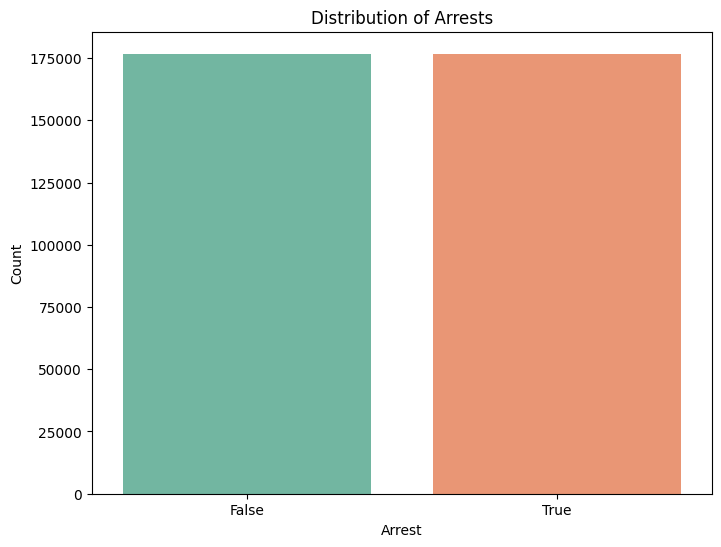

In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

total = len(x_train)
# contamos cuantos arrestos hay
arrests_count = y_train_res.value_counts()
arrest = arrests_count.get(True)
non_arrest = arrests_count.get(False)
print(f'Porcentage of arrests: {arrest / total * 100:.2f}%')
print(f'Porcentage of non arrests: {non_arrest / total * 100:.2f}%')

# Vemos la distribucon de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res, palette='Set2')
plt.title('Distribution of Arrests')
plt.xlabel('Arrest')
plt.ylabel('Count')
plt.show()

### Conclusiones

El dataset final termino siendo mas grande, en terminos de columnas, que el dataset original debido a la codificacion elegida para algunas de las variables categoricas como la fecha y las coordenadas geograficas en pos de obtener un formato mas "aprendible" por un modelo de Machine Learning. Incluso no solo se cambio el formato sino que se generaron nuevas features basadas en la fecha, la latitud y logitud. Como se mostro en secciones anteriores el uso de PCA para las variables elegidas no fue satisfactorio, por lo que se opto por no aplicar PCA y utilizar un criterio de reduccion de dimensionalidad basado en la informacion mutua y la correlacion entre las variables. En este dataset la reduccion fue ventajosa, ya que habia demasiadas variables que aportaban informacion geografica y que podian considerarse redundantes. Cabe aclarar que en un proceso de entrenamiento real la transformacion y seleccion de caracteristicas seria iterativa teniendo como punto de partida de dataset al cual se llego en este trabajo. 